In [15]:
import numpy as np 
import pandas as pd 

from keras import models, layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cusersmarildownloadsstaatlichesstaatttf/staat.ttf
/kaggle/input/reviewstripadvisor/tripadvisor_hotel_reviews.csv


In [16]:
best_font = fm.FontProperties(fname='../input/cusersmarildownloadsstaatlichesstaatttf/staat.ttf')

In [17]:
df = pd.read_csv('../input/reviewstripadvisor/tripadvisor_hotel_reviews.csv')
df = df[['Review','Rating']]
df = df.dropna()
positive = df[(df['Rating'] == 5)].sample(3214,random_state=100)
negative = df[(df['Rating'] == 2) | (df['Rating'] == 1)]
df = pd.concat([negative,positive])
df = df.reset_index(drop=True)

df['Rating'] = df['Rating'].apply(lambda x : 1 if x==5 else 0)

In [18]:
df.tail()

,Review,Rating
6423,"classy hotel took wife american long weekend, ...",1
6424,not bad word say excellence husband stayed exc...,1
6425,"treat good room glimpse bridge, thought room, ...",1
6426,"loved stayed 2 weeks march wonderful, checkin ...",1
6427,"loved minute stay, san francisco conference da...",1


In [19]:
df['Rating'].value_counts()

0    3214
1    3214
Name: Rating, dtype: int64

In [20]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def df_processing(text):
    return_arr = []
    text = re.sub(r"[^a-zA-Z]"," ",text)
    text = re.sub(r" {2,}"," ",text)
    text = text.lower()
    words = word_tokenize(text)
    s = PorterStemmer()
    stopword = stopwords.words('english')
    for t in words:
        if t not in stopword:
            return_arr.append(t)
            
    return_arr = [s.stem(w) for w in return_arr]
    return return_arr

df['processing'] = df['Review'].apply(df_processing)

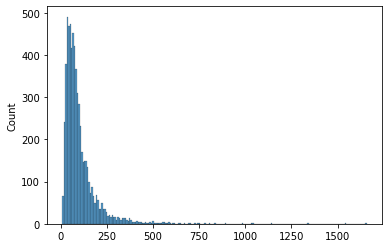

In [21]:
len_arr = []
for i in range(len(df)):
    len_arr.append(len(df.loc[i,'processing']))
    
import seaborn as sns
sns.histplot(len_arr);

In [22]:
#X = pd.DataFrame(X)
#X = X.fillna(0)
#X = X.loc[:,:250]
#X= X.to_numpy()
#y = np.array(df['Rating'])
#X = X.reshape(5584,251,1)
#X.shape, y.shape

In [23]:
df

,Review,Rating,processing
0,ok nothing special charge diamond member hilto...,0,"[ok, noth, special, charg, diamond, member, hi..."
1,"poor value stayed monaco seattle july, nice ho...",0,"[poor, valu, stay, monaco, seattl, juli, nice,..."
2,horrible customer service hotel stay february ...,0,"[horribl, custom, servic, hotel, stay, februar..."
3,disappointed say anticipating stay hotel monac...,0,"[disappoint, say, anticip, stay, hotel, monaco..."
4,great location need internally upgrade advanta...,0,"[great, locat, need, intern, upgrad, advantag,..."
...,...,...,...
6423,"classy hotel took wife american long weekend, ...",1,"[classi, hotel, took, wife, american, long, we..."
6424,not bad word say excellence husband stayed exc...,1,"[bad, word, say, excel, husband, stay, excel, ..."
6425,"treat good room glimpse bridge, thought room, ...",1,"[treat, good, room, glimps, bridg, thought, ro..."
6426,"loved stayed 2 weeks march wonderful, checkin ...",1,"[love, stay, week, march, wonder, checkin, sta..."


In [24]:
def df_processing2(text):
    return_arr = []
    text = re.sub(r"[^a-z]"," ",text)
    text = re.sub(r" {2,}"," ",text)
    return text

negative_sentences = df[df['Rating'] ==0]['processing']
positive_sentences = df[df['Rating'] ==1]['processing']

negative_sentences = str(list(negative_sentences))
negative_sentences = df_processing2(negative_sentences)

negative_sentences = negative_sentences.split(' ')
negative_sentences = pd.DataFrame(negative_sentences)[0].value_counts()
negative_sentences = pd.DataFrame(negative_sentences)

positive_sentences = str(list(positive_sentences))
positive_sentences = df_processing2(positive_sentences)

positive_sentences = positive_sentences.split(' ')
positive_sentences = pd.DataFrame(positive_sentences)[0].value_counts()
positive_sentences = pd.DataFrame(positive_sentences)

con = pd.concat([negative_sentences,positive_sentences],axis=1)

con.columns = ['negative','positive']

con = con.dropna()

con['negative_value'] = con[['negative','positive']].apply(lambda x : x[0]/(x[0]+x[1]) *-1,axis=1)
con['positive_value'] = con[['negative','positive']].apply(lambda x : x[1]/(x[0]+x[1]),axis=1)

con['total_value'] = con['negative_value'] + con['positive_value']
con = con.reset_index()
con = con.drop(['negative','positive','negative_value','positive_value'],axis=1)
word_index =con['index'].to_list()
con = np.array(con)

In [25]:

from tqdm import tqdm

X = []
for sen in tqdm(df['processing']):
    word_arr =[]
    for word in sen:
        if word in word_index:
            word_arr.append(float(con[con[:,0] ==word,1]))
        else:
            word_arr.append(0)
    X.append(word_arr)

100%|██████████| 6428/6428 [03:23<00:00, 31.58it/s]


In [26]:

X = pd.DataFrame(X)
X = X.fillna(0)
X = X.loc[:,:250]
X= X.to_numpy()
y = np.array(df['Rating'])
#X = X.reshape(6428,251,1)  That was the original reshape
X = X.reshape(-1,251,1)
X.shape, y.shape

((6428, 251, 1), (6428,))

In [27]:
#from tensorflow.keras.layers import Embedding, Dense,LSTM
#from tensorflow.keras.models import Sequential

#model = Sequential()
#model.add(LSTM(251,input_shape=X.shape[1:],activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
#model.summary()

In [28]:
from tensorflow.keras.layers import Embedding, Dense,LSTM
from tensorflow.keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(LSTM(251,input_shape=X.shape[1:]))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.00003),
              loss='binary_crossentropy', metrics=['acc'])

model.fit(X,y, batch_size=256, epochs=20, validation_split=0.3)

Epoch 1/20
18/18 [==============================] - 37s 2s/step - loss: 0.6921 - acc: 0.6891 - val_loss: 0.7029 - val_acc: 0.0021
Epoch 2/20
18/18 [==============================] - 35s 2s/step - loss: 0.6879 - acc: 0.7030 - val_loss: 0.7152 - val_acc: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 35s 2s/step - loss: 0.6810 - acc: 0.7210 - val_loss: 0.7406 - val_acc: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 34s 2s/step - loss: 0.6671 - acc: 0.7145 - val_loss: 0.8567 - val_acc: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 35s 2s/step - loss: 0.5707 - acc: 0.7144 - val_loss: 1.1666 - val_acc: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 34s 2s/step - loss: 0.4776 - acc: 0.7087 - val_loss: 1.3658 - val_acc: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 33s 2s/step - loss: 0.4393 - acc: 0.7171 - val_loss: 1.4345 - val_acc: 0.0000e+00
Epoch 8/20
18/18 [==============================] - 33s 2s/step - 

In [31]:
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

kernel_weights = weights[0]
recurrent_kernel_weights = weights[1]
bias = weights[2]

n = 1
units = 251  # LSTM layers  

Wi = kernel_weights[:, 0:units]
Wf = kernel_weights[:, units:2 * units]
Wc = kernel_weights[:, 2 * units:3 * units]
Wo = kernel_weights[:, 3 * units:]


Ui = recurrent_kernel_weights[:, 0:units]
Uf = recurrent_kernel_weights[:, units:2 * units]
Uc = recurrent_kernel_weights[:, 2 * units:3 * units]
Uo = recurrent_kernel_weights[:, 3 * units:]


bi = bias[0:units]
bf = bias[units:2 * units]
bc = bias[2 * units:3 * units]
bo = bias[3 * units:]

In [34]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [35]:
def make_plot(number):
    ht_1 = np.zeros(n * units).reshape(n, units)
    Ct_1 = np.zeros(n * units).reshape(n, units)

    h_t_value = []

    influence_h_t_value = []
    for t in range(0, len(X[number,:])):
        xt = np.array(X[number,t])
        ft = sigmoid(np.dot(xt, Wf) + np.dot(ht_1, Uf) + bf)  # forget gate
        influence_ft = (np.dot(ht_1, Uf))/(np.dot(xt, Wf) + np.dot(ht_1, Uf) + bf) * ft

        it = sigmoid(np.dot(xt, Wi) + np.dot(ht_1, Ui) + bi)  # input gate
        influence_it = (np.dot(ht_1, Ui))/(np.dot(xt, Wi) + np.dot(ht_1, Ui) + bi) * it

        ot = sigmoid(np.dot(xt, Wo) + np.dot(ht_1, Uo) + bo)  # output gate
        influence_ot = np.dot(ht_1, Uo) / (np.dot(xt, Wo) + np.dot(ht_1, Uo) + bo) * ot

        gt =  np.tanh(np.dot(xt, Wc) + np.dot(ht_1, Uc) + bc)
        influence_gt =np.dot(ht_1, Uc) / (np.dot(xt, Wc) + np.dot(ht_1, Uc) + bc) * gt

        Ct = ft * Ct_1 + it * gt
        influence_ct = influence_ft * Ct_1 + influence_it * influence_gt
        ht = ot * np.tanh(Ct)
        influence_ht = influence_ot * (influence_ct/Ct) * ht

        influence_h_t_value.append(influence_ht)

        ht_1 = ht  
        Ct_1 = Ct  

        h_t_value.append(ht)

    influence_h_t_value.append(h_t_value[-1])
    for i in range(len(influence_h_t_value)-1,0,-1):
        influence_h_t_value[i] = influence_h_t_value[i] - influence_h_t_value[i-1]

    influence_h_t_value = influence_h_t_value[1:]

    impact_columns = np.dot(influence_h_t_value,weights[3]) + (weights[4]/units)

    if model.predict(X[number:number+1]) > 0.5:
        b_color = 'lightgreen'
    else:
        b_color ='lightcyan'

    fig = plt.figure(figsize=(15,3),facecolor=b_color)

    for k in range(len(df.loc[number,'processing'])):
        s = df.loc[number,'processing'][k]
        va = round(float(impact_columns[k]),2)
        if va > 0.5:
            color ='green'
        elif va< -0.3:
            color ='blue'
        else:
            color ='black'

        if k < 17:
            plt.text(s=s, x=k*0.7, y=0,font=best_font,fontsize=20,color=color,va='center',ha='center')
            plt.text(s=va,x=k*0.7, y=-0.1,font=best_font,fontsize=20,color=color,va='center',ha='center')
        elif k < 34:
            plt.text(s=s, x=k*0.7 - 17*0.7, y=-0.2,font=best_font,fontsize=20,color=color,va='center',ha='center')
            plt.text(s=va,x=k*0.7- 17*0.7, y=-0.3,font=best_font,fontsize=20,color=color,va='center',ha='center')
        else:
            plt.text(s=s, x=k*0.7 - 34*0.7, y=-0.4,font=best_font,fontsize=20,color=color,va='center',ha='center')
            plt.text(s=va,x=k*0.7- 34*0.7, y=-0.5,font=best_font,fontsize=20,color=color,va='center',ha='center')

    plt.xlim(0,10)
    plt.ylim(-0.5,0.1)
    plt.axis('off')
    plt.show()

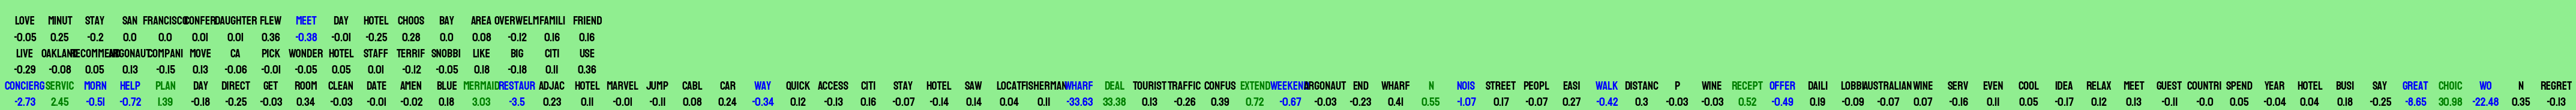

In [36]:
make_plot(6427)

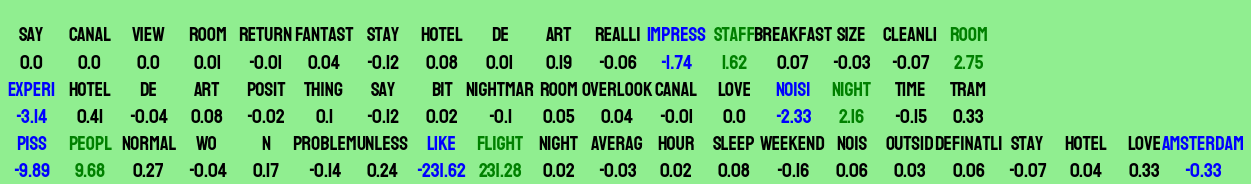

In [37]:
make_plot(6000)

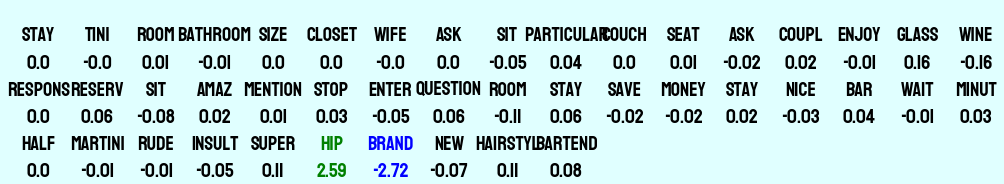

In [38]:
make_plot(220)

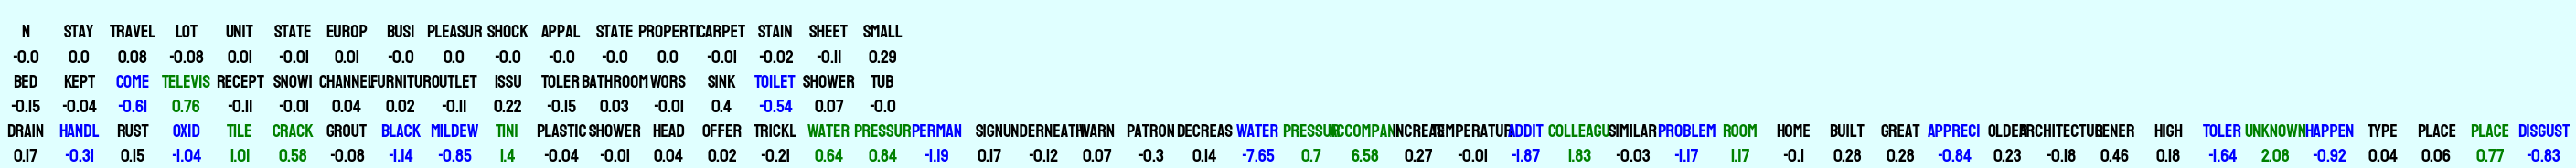

In [39]:
make_plot(200)

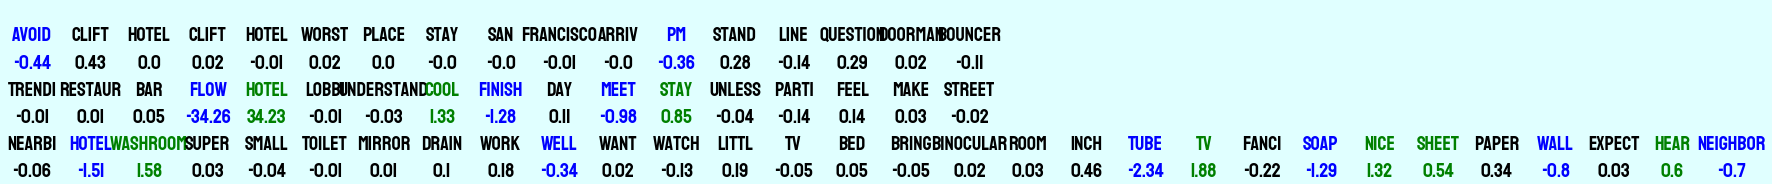

In [40]:
make_plot(216)

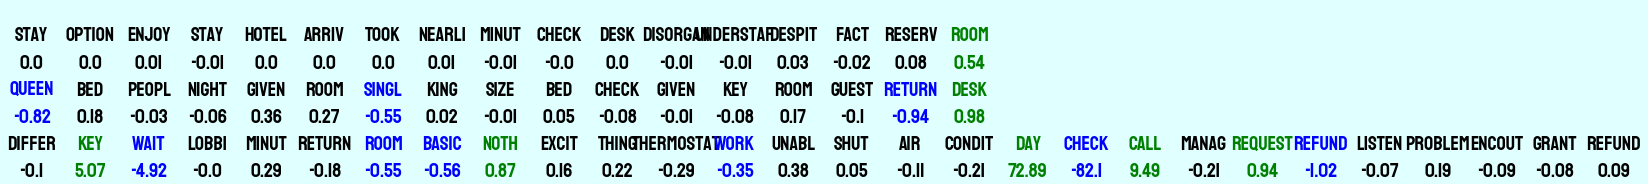

In [41]:
make_plot(120)

In [43]:
def make_plot(number):
    ht_1 = np.zeros(n * units).reshape(n, units)
    Ct_1 = np.zeros(n * units).reshape(n, units)

    h_t_value = []

    influence_h_t_value = []
    for t in range(0, len(X[number,:])):
        xt = np.array(X[number,t])
        ft = sigmoid(np.dot(xt, Wf) + np.dot(ht_1, Uf) + bf)  # forget gate
        influence_ft = (np.dot(ht_1, Uf))/(np.dot(xt, Wf) + np.dot(ht_1, Uf) + bf) * ft

        it = sigmoid(np.dot(xt, Wi) + np.dot(ht_1, Ui) + bi)  # input gate
        influence_it = (np.dot(ht_1, Ui))/(np.dot(xt, Wi) + np.dot(ht_1, Ui) + bi) * it

        ot = sigmoid(np.dot(xt, Wo) + np.dot(ht_1, Uo) + bo)  # output gate
        influence_ot = np.dot(ht_1, Uo) / (np.dot(xt, Wo) + np.dot(ht_1, Uo) + bo) * ot

        gt =  np.tanh(np.dot(xt, Wc) + np.dot(ht_1, Uc) + bc)
        influence_gt =np.dot(ht_1, Uc) / (np.dot(xt, Wc) + np.dot(ht_1, Uc) + bc) * gt

        Ct = ft * Ct_1 + it * gt
        influence_ct = influence_ft * Ct_1 + influence_it * influence_gt
        ht = ot * np.tanh(Ct)
        influence_ht = influence_ot * (influence_ct/Ct) * ht

        influence_h_t_value.append(influence_ht)

        ht_1 = ht  # hidden state, previous memory state
        Ct_1 = Ct  # cell state, previous carry state

        h_t_value.append(ht)

    influence_h_t_value.append(h_t_value[-1])
    for i in range(len(influence_h_t_value)-1,0,-1):
        influence_h_t_value[i] = influence_h_t_value[i] - influence_h_t_value[i-1]

    influence_h_t_value = influence_h_t_value[1:]

    impact_columns = np.dot(influence_h_t_value,weights[3]) + (weights[4]/units)
    print(model.predict(X[number:number+1]))
    if model.predict(X[number:number+1]) > 0.5:
        b_color = 'lightgreen'
    else:
        b_color ='lightcyan'

    fig = plt.figure(figsize=(15,3),facecolor=b_color)

    for k in range(len(df.loc[number,'processing'])):
        s = df.loc[number,'processing'][k]
        va = round(float(impact_columns[k]),2)
        if va > 0.5:
            color ='green'
        elif va< -0.3:
            color ='blue'
        else:
            color ='black'

        if k < 17:
            plt.text(s=s, x=k*0.7, y=0,fontsize=14,color=color,va='center',ha='center')
            plt.text(s=va,x=k*0.7, y=-0.1,fontsize=14,color=color,va='center',ha='center')
        elif k < 34:
            plt.text(s=s, x=k*0.7 - 17*0.7, y=-0.2,fontsize=14,color=color,va='center',ha='center')
            plt.text(s=va,x=k*0.7- 17*0.7, y=-0.3,fontsize=14,color=color,va='center',ha='center')
        else:
            plt.text(s=s, x=k*0.7 - 34*0.7, y=-0.4,fontsize=14,color=color,va='center',ha='center')
            plt.text(s=va,x=k*0.7- 34*0.7, y=-0.5,fontsize=14,color=color,va='center',ha='center')

    plt.xlim(0,10)
    plt.ylim(-0.5,0.1)
    plt.axis('off')
    plt.show()

[[0.8537899]]


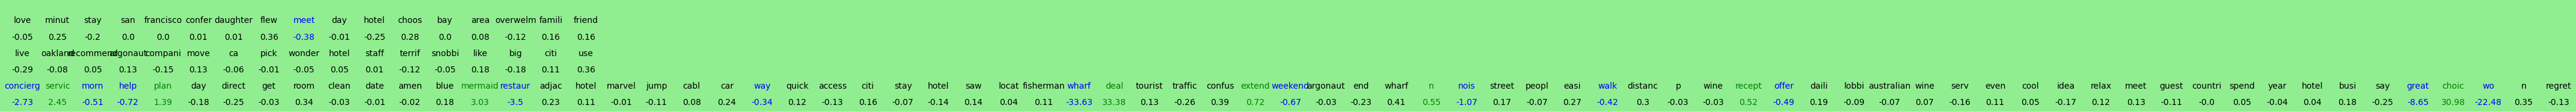

In [44]:
make_plot(6427)

[[0.8522084]]


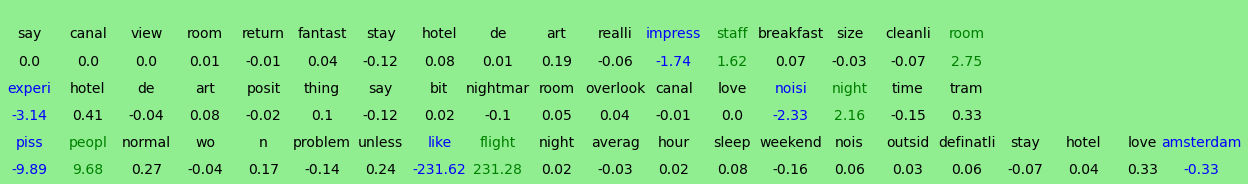

In [45]:
make_plot(6000)

[[0.02788565]]


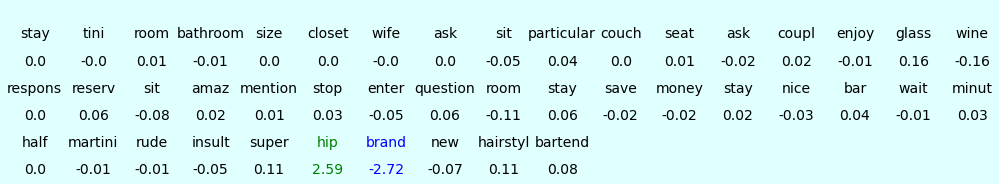

In [46]:
make_plot(220)

[[0.0278317]]


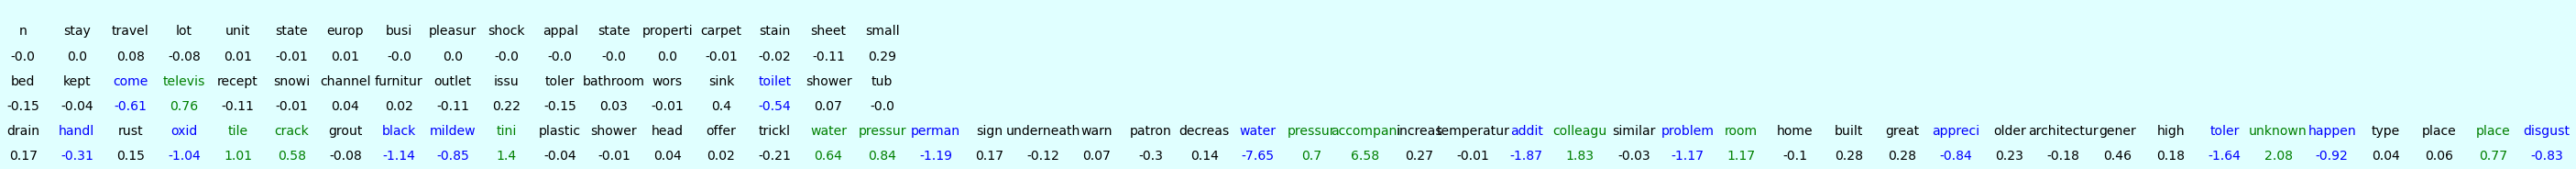

In [47]:
make_plot(200)